**UHC Benchmarking Analysis**

This analysis has been done on Google Collab due to compute constraints on local system. One can run this on local system by changing the path of benefits & claims csv files.

In [68]:
import pandas as pd
import numpy as np
import itertools
import logging
from pathlib import Path
from collections import Counter
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [3]:
member_df = pd.read_csv("/content/DE1_0_2009_Beneficiary_Summary_File_Sample_20.csv")
claims_df = pd.read_csv("/content/DE1_0_2008_to_2010_Outpatient_Claims_Sample_20.csv", low_memory=False)

In [5]:
print(member_df.shape)
print(claims_df.shape)

(114641, 32)
(790044, 76)


In [6]:
print(member_df.head(2))

        DESYNPUF_ID  BENE_BIRTH_DT  BENE_DEATH_DT  BENE_SEX_IDENT_CD  \
0  000002F7E0A96C32       19190701            NaN                  2   
1  00001C24EE7B06AC       19360501            NaN                  1   

   BENE_RACE_CD BENE_ESRD_IND  SP_STATE_CODE  BENE_COUNTY_CD  \
0             2             0              5             400   
1             1             0             11             530   

   BENE_HI_CVRAGE_TOT_MONS  BENE_SMI_CVRAGE_TOT_MONS  ...  SP_STRKETIA  \
0                        0                         0  ...            2   
1                       12                        12  ...            2   

   MEDREIMB_IP  BENRES_IP  PPPYMT_IP  MEDREIMB_OP  BENRES_OP  PPPYMT_OP  \
0          0.0        0.0        0.0          0.0        0.0        0.0   
1          0.0        0.0        0.0        200.0       40.0        0.0   

   MEDREIMB_CAR  BENRES_CAR  PPPYMT_CAR  
0           0.0         0.0         0.0  
1         800.0       260.0         0.0  

[2 rows x 32 c

In [7]:
print(claims_df.head(2))

        DESYNPUF_ID           CLM_ID  SEGMENT  CLM_FROM_DT  CLM_THRU_DT  \
0  00001C24EE7B06AC  684562269783396        1   20090404.0   20090404.0   
1  00001C24EE7B06AC  684012269893042        1   20100310.0   20100310.0   

  PRVDR_NUM  CLM_PMT_AMT  NCH_PRMRY_PYR_CLM_PD_AMT  AT_PHYSN_NPI  \
0    1100SK        200.0                       0.0  1.298827e+09   
1    1100SK        500.0                       0.0  1.298827e+09   

   OP_PHYSN_NPI  ...  HCPCS_CD_36  HCPCS_CD_37 HCPCS_CD_38 HCPCS_CD_39  \
0           NaN  ...          NaN          NaN         NaN         NaN   
1           NaN  ...          NaN          NaN         NaN         NaN   

  HCPCS_CD_40 HCPCS_CD_41 HCPCS_CD_42 HCPCS_CD_43 HCPCS_CD_44 HCPCS_CD_45  
0         NaN         NaN         NaN         NaN         NaN         NaN  
1         NaN         NaN         NaN         NaN         NaN         NaN  

[2 rows x 76 columns]


Create column that contains all the chronic conditions for a member.
Also create a variable that contains total number of chronic conditions for the member.

In [8]:
chronic_cols = [col for col in member_df.columns if "SP" in col and col != "SP_STATE_CODE"]

# === FUNCTIONS ===
def get_active_conditions(row):
    """Returns list of chronic conditions present in a row."""
    return [col for col in chronic_cols if row[col] == 1]


def count_conditions(row):
    """Counts how many chronic conditions are present."""
    return sum(row[col] == 1 for col in chronic_cols)


# === ENRICH DATA ===
member_df["active_conditions"] = member_df.apply(get_active_conditions, axis=1)
member_df["active_conditions_str"] = member_df["active_conditions"].apply(lambda x: ", ".join(x))
member_df["total_conditions"] = member_df.apply(count_conditions, axis=1)

In [11]:
# Merge claims and member data via inner join since subsequent analysis doesn't require non-members.
merge_df = claims_df.merge(
    member_df[["DESYNPUF_ID", "active_conditions", "total_conditions"]],
    on="DESYNPUF_ID",
    how="inner",
)

In [12]:
print(merge_df.shape)

(788049, 78)


In [16]:
id_cols = ["DESYNPUF_ID","CLM_ID"]
chronic_cols = ["active_conditions","total_conditions"]
diagnosis_cols = [f'ICD9_DGNS_CD_{i}' for i in range(1, 11)]

sample_data = merge_df[id_cols+chronic_cols+diagnosis_cols]

print(sample_data.head(2))

        DESYNPUF_ID           CLM_ID active_conditions  total_conditions  \
0  00001C24EE7B06AC  684562269783396     [SP_ISCHMCHT]                 1   
1  00001C24EE7B06AC  684012269893042     [SP_ISCHMCHT]                 1   

  ICD9_DGNS_CD_1 ICD9_DGNS_CD_2 ICD9_DGNS_CD_3 ICD9_DGNS_CD_4 ICD9_DGNS_CD_5  \
0          74560          V5861          42731            NaN            NaN   
1           7879          V4589            NaN            NaN            NaN   

  ICD9_DGNS_CD_6 ICD9_DGNS_CD_7 ICD9_DGNS_CD_8 ICD9_DGNS_CD_9 ICD9_DGNS_CD_10  
0            NaN            NaN            NaN            NaN             NaN  
1            NaN            NaN            NaN            NaN             NaN  


Transform dataset to melt and explode, such that every row contains all the diagnosis codes and chronic conditions of the member. For example, if a member has chronic condition X, Y and Z, and has a claim ID with diagnosis M, N, P; then the transformed dataset would contain 6 rows.

In [21]:
code_df = pd.melt(
    sample_data,
    id_vars=["DESYNPUF_ID", "CLM_ID", "active_conditions", "total_conditions"],
    value_vars=diagnosis_cols,
    var_name="code_type",
    value_name="code",
)

code_df = code_df.dropna(subset=["code"])
code_df["code"] = code_df["code"].str.strip()


code_df = code_df.explode("active_conditions")
code_df = code_df.rename(columns={"active_conditions": "chronic_condition"})
code_df = code_df[code_df["chronic_condition"].notnull() & (code_df["chronic_condition"] != "")]
code_df["weight"] = 1 / code_df["total_conditions"]

print(code_df.head())

         DESYNPUF_ID           CLM_ID chronic_condition  total_conditions  \
0   00001C24EE7B06AC  684562269783396       SP_ISCHMCHT                 1   
1   00001C24EE7B06AC  684012269893042       SP_ISCHMCHT                 1   
17  0000DCD33779ED8A  684572269759078       SP_ALZHDMTA                 3   
17  0000DCD33779ED8A  684572269759078            SP_CHF                 3   
17  0000DCD33779ED8A  684572269759078           SP_CNCR                 3   

         code_type   code    weight  
0   ICD9_DGNS_CD_1  74560  1.000000  
1   ICD9_DGNS_CD_1   7879  1.000000  
17  ICD9_DGNS_CD_1  79677  0.333333  
17  ICD9_DGNS_CD_1  79677  0.333333  
17  ICD9_DGNS_CD_1  79677  0.333333  


Since I did not have access to mapping between diagnosis code and chronic condition, following code is to create mapping based on current data.

The assumption here is that a member would go to a provider to treat one of his or her chronic conditions. And hence, every claim is to diagnose and treat only one chronic condition. Since members could have multiple conditions, the below logic identifies the condition that is most likely based on diagnosis code.

The logic used is similar to TF - IDF used in NLP.

In [32]:
pair_counts = (
    code_df.groupby(["code", "chronic_condition"])
    .agg({"weight": "sum"})
    .reset_index()
)

pair_counts["normalized_weight"] = (
    pair_counts.groupby("code")["weight"].transform(lambda x: x / x.sum())
)

condition_code_counts = (
    pair_counts.groupby("chronic_condition")["code"]
    .nunique()
    .reset_index()
    .rename(columns={"code": "code_count"})
)
condition_code_counts["idf_weight"] = 1 / np.log1p(condition_code_counts["code_count"])

pair_counts = pair_counts.merge(condition_code_counts, on="chronic_condition", how="left")

pair_counts["adjusted_weight"] = pair_counts["weight"] * pair_counts["idf_weight"]

top_mapping = (
    pair_counts.sort_values(["code", "adjusted_weight"], ascending=[True, False])
    .drop_duplicates(subset="code", keep="first")
    .reset_index(drop=True)
)

code_to_condition = dict(zip(top_mapping["code"], top_mapping["chronic_condition"]))

sample_data["all_codes"] = sample_data[diagnosis_cols].values.tolist()

def get_mapped_conditions(code_list, mapping):
    conditions = [
        mapping.get(code.strip())
        for code in code_list
        if pd.notna(code) and mapping.get(code.strip())
    ]
    return conditions

sample_data["mapped_conditions"] = sample_data["all_codes"].apply(
    lambda x: get_mapped_conditions(x, code_to_condition)
)

def assign_primary_condition(conditions):
    if not conditions:
        return None
    return pd.Series(conditions).value_counts().idxmax()


sample_data["assigned_condition"] = sample_data["mapped_conditions"].apply(
    assign_primary_condition
    )

def override_with_single_member_condition(row):
    conditions = row["active_conditions"]
    if len(conditions) == 1:
        return conditions[0]  # override with the only chronic condition
    return row["assigned_condition"]


sample_data["assigned_condition"] = sample_data.apply(
    override_with_single_member_condition, axis=1
)

sample_data = sample_data.loc[sample_data['total_conditions'] > 0, ].reset_index(drop=True)

print(sample_data.head())

        DESYNPUF_ID           CLM_ID               active_conditions  \
0  00001C24EE7B06AC  684562269783396                   [SP_ISCHMCHT]   
1  00001C24EE7B06AC  684012269893042                   [SP_ISCHMCHT]   
2  0000DCD33779ED8A  684572269759078  [SP_ALZHDMTA, SP_CHF, SP_CNCR]   
3  0000DCD33779ED8A  684902269547320  [SP_ALZHDMTA, SP_CHF, SP_CNCR]   
4  0000DCD33779ED8A  684862269518830  [SP_ALZHDMTA, SP_CHF, SP_CNCR]   

   total_conditions ICD9_DGNS_CD_1 ICD9_DGNS_CD_2 ICD9_DGNS_CD_3  \
0                 1          74560          V5861          42731   
1                 1           7879          V4589            NaN   
2                 3          79677          79389            NaN   
3                 3          34590            431          71500   
4                 3           4011            NaN            NaN   

  ICD9_DGNS_CD_4 ICD9_DGNS_CD_5 ICD9_DGNS_CD_6 ICD9_DGNS_CD_7 ICD9_DGNS_CD_8  \
0            NaN            NaN            NaN            NaN            NaN  

In [33]:
print(sample_data["assigned_condition"].value_counts(normalize=True))

assigned_condition
SP_ISCHMCHT    0.824185
SP_DIABETES    0.108076
SP_DEPRESSN    0.017808
SP_CHF         0.017152
SP_OSTEOPRS    0.009865
SP_ALZHDMTA    0.009300
SP_RA_OA       0.004479
SP_CHRNKIDN    0.003878
SP_CNCR        0.002520
SP_COPD        0.001996
SP_STRKETIA    0.000740
Name: proportion, dtype: float64


In [34]:
merge_df.columns

Index(['DESYNPUF_ID', 'CLM_ID', 'SEGMENT', 'CLM_FROM_DT', 'CLM_THRU_DT',
       'PRVDR_NUM', 'CLM_PMT_AMT', 'NCH_PRMRY_PYR_CLM_PD_AMT', 'AT_PHYSN_NPI',
       'OP_PHYSN_NPI', 'OT_PHYSN_NPI', 'NCH_BENE_BLOOD_DDCTBL_LBLTY_AM',
       'ICD9_DGNS_CD_1', 'ICD9_DGNS_CD_2', 'ICD9_DGNS_CD_3', 'ICD9_DGNS_CD_4',
       'ICD9_DGNS_CD_5', 'ICD9_DGNS_CD_6', 'ICD9_DGNS_CD_7', 'ICD9_DGNS_CD_8',
       'ICD9_DGNS_CD_9', 'ICD9_DGNS_CD_10', 'ICD9_PRCDR_CD_1',
       'ICD9_PRCDR_CD_2', 'ICD9_PRCDR_CD_3', 'ICD9_PRCDR_CD_4',
       'ICD9_PRCDR_CD_5', 'ICD9_PRCDR_CD_6', 'NCH_BENE_PTB_DDCTBL_AMT',
       'NCH_BENE_PTB_COINSRNC_AMT', 'ADMTNG_ICD9_DGNS_CD', 'HCPCS_CD_1',
       'HCPCS_CD_2', 'HCPCS_CD_3', 'HCPCS_CD_4', 'HCPCS_CD_5', 'HCPCS_CD_6',
       'HCPCS_CD_7', 'HCPCS_CD_8', 'HCPCS_CD_9', 'HCPCS_CD_10', 'HCPCS_CD_11',
       'HCPCS_CD_12', 'HCPCS_CD_13', 'HCPCS_CD_14', 'HCPCS_CD_15',
       'HCPCS_CD_16', 'HCPCS_CD_17', 'HCPCS_CD_18', 'HCPCS_CD_19',
       'HCPCS_CD_20', 'HCPCS_CD_21', 'HCPCS_CD_22', 'HC

In [84]:
combined_data = merge_df[['DESYNPUF_ID', 'CLM_ID', 'PRVDR_NUM', 'CLM_PMT_AMT', 'AT_PHYSN_NPI', 'active_conditions']].merge(sample_data[['DESYNPUF_ID', 'CLM_ID', 'assigned_condition']],
                                                                                      on= ['DESYNPUF_ID', 'CLM_ID'], how='inner')
combined_data = combined_data.loc[combined_data['CLM_PMT_AMT'] > 0, ].reset_index(drop=True)
combined_data["active_conditions_list"] = combined_data["active_conditions"].apply(lambda x: ", ".join(x))

In [85]:
combined_data.head()

,DESYNPUF_ID,CLM_ID,PRVDR_NUM,CLM_PMT_AMT,AT_PHYSN_NPI,active_conditions,assigned_condition,active_conditions_list
0,00001C24EE7B06AC,684562269783396,1100SK,200.0,1.298827e+09,[SP_ISCHMCHT],SP_ISCHMCHT,SP_ISCHMCHT
1,00001C24EE7B06AC,684012269893042,1100SK,500.0,1.298827e+09,[SP_ISCHMCHT],SP_ISCHMCHT,SP_ISCHMCHT
2,0000DCD33779ED8A,684572269759078,1101MA,90.0,2.788685e+09,"[SP_ALZHDMTA, SP_CHF, SP_CNCR]",SP_ISCHMCHT,"SP_ALZHDMTA, SP_CHF, SP_CNCR"
3,0000DCD33779ED8A,684902269547320,3301SM,70.0,1.992593e+09,"[SP_ALZHDMTA, SP_CHF, SP_CNCR]",SP_ISCHMCHT,"SP_ALZHDMTA, SP_CHF, SP_CNCR"
4,0000DCD33779ED8A,684862269518830,1102TQ,100.0,5.398689e+09,"[SP_ALZHDMTA, SP_CHF, SP_CNCR]",SP_ISCHMCHT,"SP_ALZHDMTA, SP_CHF, SP_CNCR"


In [86]:
benchmarking_data_1 = combined_data.groupby(by = ['PRVDR_NUM','assigned_condition']).agg(
    total_cost=('CLM_PMT_AMT', 'sum'),
    unique_members=('DESYNPUF_ID', 'nunique')
).reset_index()

benchmarking_data_1['cost_per_member'] = benchmarking_data_1['total_cost'] / benchmarking_data_1['unique_members']

In [87]:
# Get index of max and min cost per member for each condition

_temp = benchmarking_data_1.loc[benchmarking_data_1["unique_members"] > 5, ]
idx_max = _temp.groupby("assigned_condition")["cost_per_member"].idxmax()
idx_min = _temp.groupby("assigned_condition")["cost_per_member"].idxmin()

# Fetch the rows
highest_cost_providers = _temp.loc[idx_max].reset_index(drop=True)
lowest_cost_providers = _temp.loc[idx_min].reset_index(drop=True)

# Optionally: add a column to tag them
highest_cost_providers['cost_tag'] = 'Highest'
lowest_cost_providers['cost_tag'] = 'Lowest'

# Combine both for easy viewing
extreme_cost_providers = pd.concat([highest_cost_providers, lowest_cost_providers], ignore_index=True)


In [88]:
extreme_cost_providers.sort_values(by = ['assigned_condition', 'cost_tag'])

,PRVDR_NUM,assigned_condition,total_cost,unique_members,cost_per_member,cost_tag
0,0505QG,SP_ALZHDMTA,8220.0,7,1174.285714,Highest
10,4400YC,SP_ALZHDMTA,110.0,6,18.333333,Lowest
1,4504RU,SP_CHF,6660.0,6,1110.000000,Highest
11,17008Q,SP_CHF,250.0,7,35.714286,Lowest
2,3300KJ,SP_CHRNKIDN,23570.0,7,3367.142857,Highest
12,0900SU,SP_CHRNKIDN,3110.0,10,311.000000,Lowest
3,0502NA,SP_CNCR,7510.0,9,834.444444,Highest
13,4200ZV,SP_CNCR,1640.0,7,234.285714,Lowest
4,4500NJ,SP_COPD,3200.0,6,533.333333,Highest
14,3400ZQ,SP_COPD,790.0,6,131.666667,Lowest


In [89]:
benchmarking_data_2 = combined_data.copy()
benchmarking_data_2 = (
    benchmarking_data_2.groupby(["active_conditions_list", "PRVDR_NUM"])
    .agg(
        total_cost=("CLM_PMT_AMT", "sum"),
        unique_members=("DESYNPUF_ID", pd.Series.nunique)
    )
    .reset_index()
)

# Compute cost per member
benchmarking_data_2["cost_per_member"] = (
    benchmarking_data_2["total_cost"] / benchmarking_data_2["unique_members"]
)


In [90]:
benchmarking_data_2.tail()

,active_conditions_list,PRVDR_NUM,total_cost,unique_members,cost_per_member
262126,SP_STRKETIA,5000YH,40.0,1,40.0
262127,SP_STRKETIA,5001YQ,20.0,1,20.0
262128,SP_STRKETIA,5200DG,200.0,1,200.0
262129,SP_STRKETIA,6700HC,400.0,1,400.0
262130,SP_STRKETIA,6725WN,820.0,1,820.0


In [91]:
def plot_cost_distribution(df, condition, bins=30):
    summary = df[df['active_conditions_list'] == condition]

    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.histplot(summary["cost_per_member"], bins=bins, kde=True, ax=ax)
    ax.set_title(f"Cost per Member Distribution\n(Chronic Condition: {condition})")
    ax.set_xlabel("Cost per Member ($)")
    ax.set_ylabel("Number of Providers")
    plt.show()

In [92]:
benchmarking_data_2.groupby('active_conditions_list')['unique_members'].sum().reset_index().sort_values(by='unique_members', ascending=False).head()
# plot_cost_distribution()

,active_conditions_list,unique_members
1588,SP_ISCHMCHT,10975
1573,"SP_DIABETES, SP_ISCHMCHT",7388
1572,SP_DIABETES,6030
1181,"SP_CHF, SP_DIABETES, SP_ISCHMCHT",5881
1196,"SP_CHF, SP_ISCHMCHT",4888


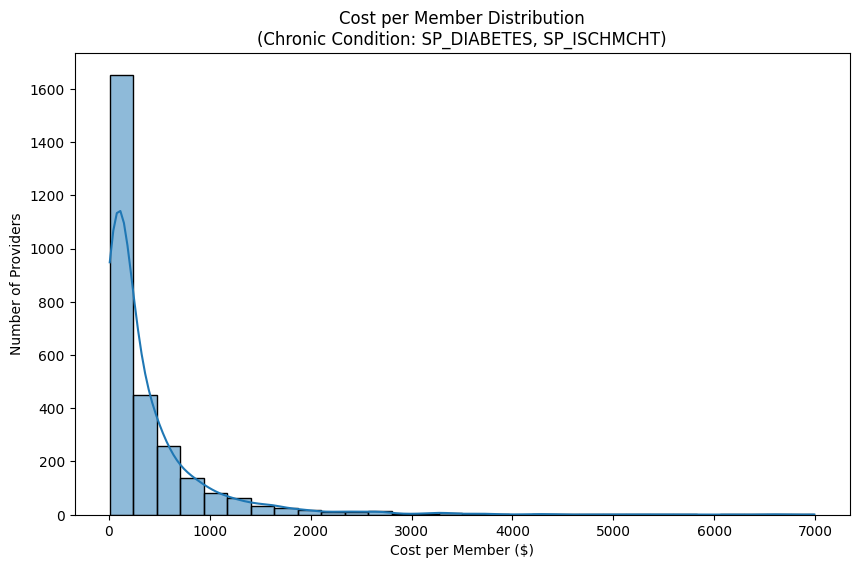

In [93]:
plot_cost_distribution(benchmarking_data_2, 'SP_DIABETES, SP_ISCHMCHT')

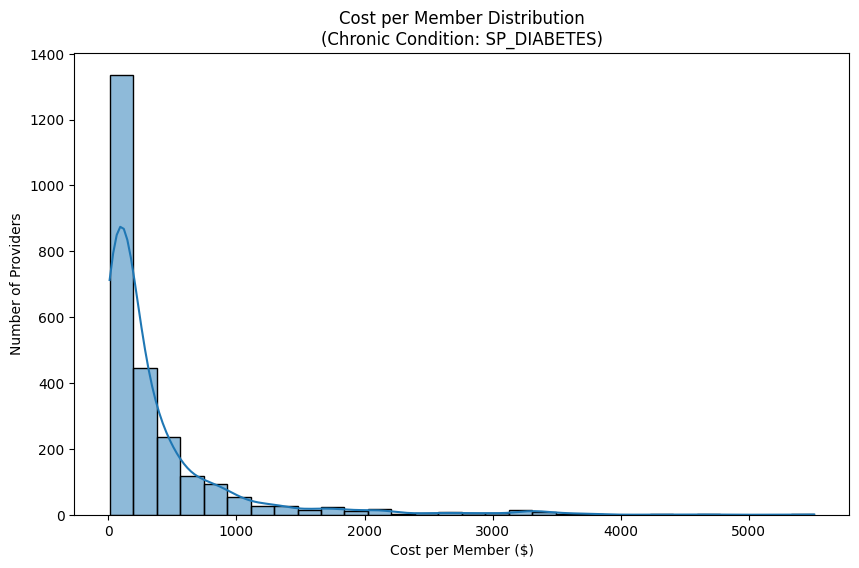

In [95]:
plot_cost_distribution(benchmarking_data_2, 'SP_DIABETES')

In [101]:
def plot_cost_distribution_min_2(df, condition, bins=30):
    df = df[df['unique_members']> 1]
    summary = df[df['active_conditions_list'] == condition]

    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.histplot(summary["cost_per_member"], bins=bins, kde=True, ax=ax)
    ax.set_title(f"Cost per Member Distribution\n(Chronic Condition (Minimum 2 Members): {condition})")
    ax.set_xlabel("Cost per Member ($)")
    ax.set_ylabel("Number of Providers")
    plt.show()

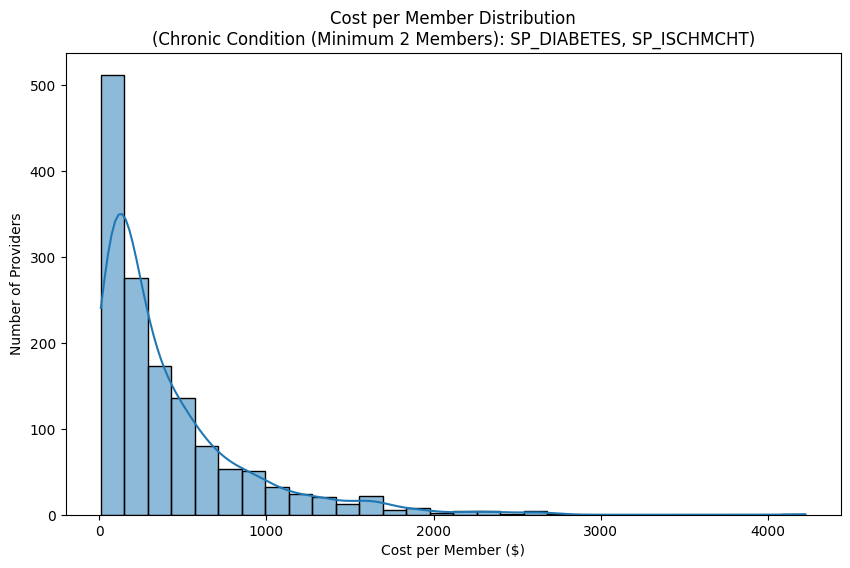

In [102]:
plot_cost_distribution_min_2(benchmarking_data_2, 'SP_DIABETES, SP_ISCHMCHT')

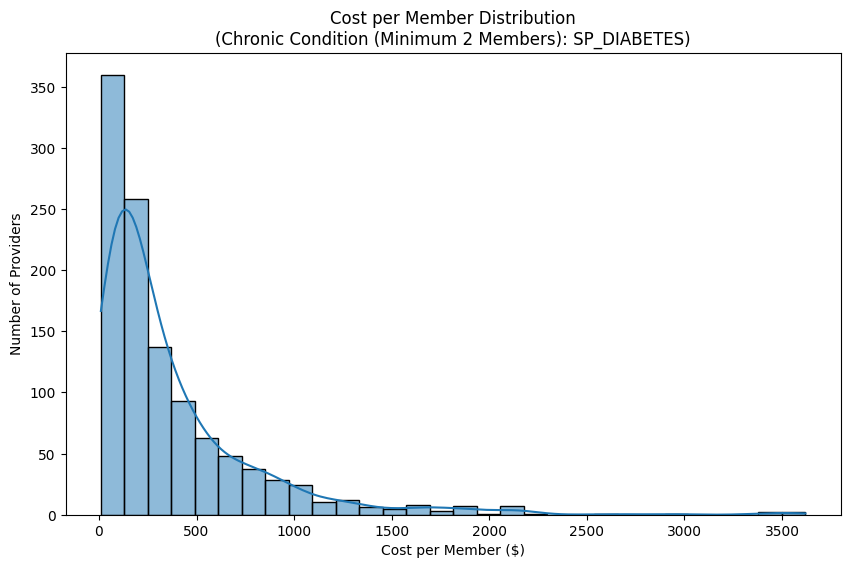

In [103]:
plot_cost_distribution_min_2(benchmarking_data_2, 'SP_DIABETES')

In [106]:
benchmarking_data_3 = combined_data[['PRVDR_NUM', 'assigned_condition', 'DESYNPUF_ID', 'CLM_PMT_AMT']]

summary_df_3 = (
    benchmarking_data_3.groupby(['PRVDR_NUM', 'assigned_condition'])
    .agg(
        total_cost=('CLM_PMT_AMT', 'sum'),
        unique_members=('DESYNPUF_ID', pd.Series.nunique)
    )
    .reset_index()
)

summary_df_3['cost_per_member'] = summary_df_3['total_cost'] / summary_df_3['unique_members']


In [107]:
summary_df_3['rank_within_condition'] = summary_df_3.groupby('assigned_condition')['cost_per_member'].rank(method='min', ascending=False)


In [109]:
def is_expensive(group):
    threshold = group['cost_per_member'].quantile(0.9)
    return group['cost_per_member'] >= threshold

summary_df_3['is_expensive'] = summary_df_3.groupby('assigned_condition', group_keys=False).apply(is_expensive).reset_index(drop=True)

In [111]:
expensive_counts = (
    summary_df_3[summary_df_3['is_expensive']]
    .groupby('PRVDR_NUM')
    .size()
    .reset_index(name='times_expensive')
)

In [112]:
consistently_expensive_providers = expensive_counts[expensive_counts['times_expensive'] >= 3]

In [115]:
consistently_expensive_providers.sort_values(by='times_expensive', ascending=False).head(10)

,PRVDR_NUM,times_expensive
1294,3400XN,5
1483,3900PT,5
80,0400AC,4
339,1001HR,4
824,2100NA,4
684,1713CU,4
362,1002RJ,4
275,0700JJ,4
1486,3900SR,4
1247,33036V,4
